# Not all seeds become plants

In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite, community 
import itertools
from cdlib import algorithms, readwrite, evaluation, TemporalClustering

## Bipartite network generation

### Data preparation

In [129]:
tot = pd.read_excel('Pasadena.xlsx')
nodes_org = tot[['Organisation', 'org_country', 'org_city_coo']].drop_duplicates()
nodes_org['bipartite'] = 1
nodes_inv = tot[['Investors', 'inv_country', 'inv_city_coo']].drop_duplicates()
nodes_org = nodes_org.rename(columns={"Organisation": "Node", "org_country": "Country", "org_city_coo": "Coo"})
nodes_inv = nodes_inv.rename(columns={"Investors": "Node","inv_country": "Country", "inv_city_coo": "Coo"})
nodes_inv['bipartite'] = 0
nodes = nodes_org.append(nodes_inv, ignore_index= True)
nodes['id'] = nodes.index

nodes = nodes.assign(coo = nodes.Coo.str.replace('(','').str.replace(')',''))
nodes= nodes.assign(coo = nodes.coo.str.split(', '))
lats = [0]*len(nodes)
longs = [0]*len(nodes)
for i in range(len(nodes)):
    if np.any(pd.isnull(nodes.coo[i])) == True: 
        lats[i] = np.nan
        longs[i] = np.nan
    else :
        lats[i] = nodes.coo[i][0]
        longs[i] = nodes.coo[i][1]
nodes = nodes.assign(lat = lats, long = longs)
nodes.lat = pd.to_numeric(nodes.lat, errors='coerce')
nodes.long = pd.to_numeric(nodes.long, errors = 'coerce')
nodes=nodes.loc[:,['Node', 'Country', 'bipartite', 'id', 'lat', 'long', 'Coo']]
nodes.to_csv("id_mapping.csv")
nodes.head()

<ipython-input-129-bebb74d81ad5>:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  nodes = nodes.assign(coo = nodes.Coo.str.replace('(','').str.replace(')',''))


,Node,Country,bipartite,id,lat,long,Coo
0,Meddy,United Arab Emirates,1,0,25.075010,55.188761,"(25.0750095, 55.18876088183319)"
1,Lemonaid Health,United States,1,1,37.779026,-122.419906,"(37.7790262, -122.4199061)"
2,Prellis Biologics,United States,1,2,37.779026,-122.419906,"(37.7790262, -122.4199061)"
3,Memed,Brazil,1,3,-23.550651,-46.633382,"(-23.5506507, -46.6333824)"
4,1859,United States,1,4,32.717420,-117.162773,"(32.7174202, -117.1627728)"


In [130]:
tot2 = pd.merge(tot, nodes[nodes['bipartite']== 1],  how='left', left_on=['Organisation','org_city_coo'], right_on = ['Node','Coo'])
tot2 = pd.merge(tot2, nodes[nodes['bipartite']== 0],  how='left', left_on=['Investors','inv_city_coo'], right_on = ['Node','Coo'])
dic = {}
for i in range(len(nodes)):
               dic[i] = {"Name": nodes.Node[i], 'Country':nodes.Country[i], 'kind': nodes.bipartite[i]}
Pallottola = tot2[tot2.columns[~tot2.columns.str.contains('Unnamed:')]]
IDs=Pallottola[['Funding type', 'Node_x']].drop_duplicates()
IDs['idx']=IDs.index
Pallottola = pd.merge(Pallottola, IDs,  how='left', left_on=['Funding type','Node_x'], right_on = ['Funding type','Node_x'])

### Graph building

In [131]:
B = nx.MultiGraph(name='org-bid')
# Add nodes with the node attribute "bipartite"
B.add_nodes_from(nodes[nodes.bipartite==0].id, bipartite=0)
B.add_nodes_from(nodes[nodes.bipartite==1].id, bipartite=1)
# Add edges only between nodes of opposite node sets
for i in range(len(Pallottola)):
    B.add_edge(Pallottola.loc[i,'id_x'], Pallottola.loc[i,'id_y'], date=pd.to_datetime(Pallottola.loc[i,'Date']).year, m_raised=Pallottola.loc[i,'USDraised_cpi'])

In [132]:
# Remove NaN node
B.remove_node(22560)

In [133]:
bid_nodes = {n for n, d in B.nodes(data=True) if d["bipartite"] == 0}
org_nodes = set(B) - bid_nodes

### Snapshot creation

In [134]:
for year in range(2000, 2021):
    locals()["SG_"+str(year)]=nx.MultiGraph()
    for x in B.edges(data=True):
        if x[2]['date']==year:
            locals()["SG_"+str(year)].add_edge(x[0],x[1], date=year, m_raised=x[2]['m_raised'])
    for x in locals()["SG_"+str(year)].nodes():
        locals()["SG_"+str(year)].nodes[x]['bipartite'] = B.nodes(data=True)[x]['bipartite']
    locals()["bid_nodes_"+str(year)] = {n for n, d in locals()["SG_"+str(year)].nodes(data=True) if d["bipartite"] == 0}
    locals()["org_nodes_"+str(year)] = set(B) - locals()["bid_nodes_"+str(year)]

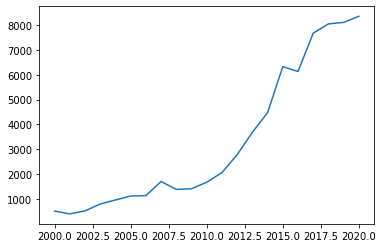

In [135]:
edges_subgraph=[]
nodes_subgraph=[]
avg_degree_subgraph=[]
for year in range(2000,2021):
    edges_subgraph.append(locals()["SG_"+str(year)].number_of_edges())
    nodes_subgraph.append(locals()["SG_"+str(year)].number_of_nodes())
    #avg_degree_subgraph.append(2*locals()["SG_"+str(year)].number_of_edges()/(locals()["SG_"+str(year)].number_of_nodes()+1))
    
plt.plot(range(2000,2021), edges_subgraph)

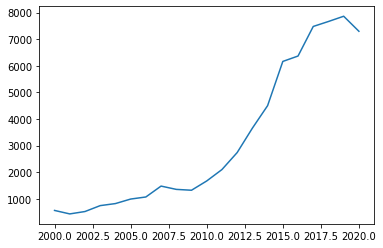

In [136]:
plt.plot(range(2000,2021), nodes_subgraph)

### Projections

There is no algorithm that projects multigraphs. The following one tries to figure out a possible solution (indeed it has some drawbacks and some arbitrary technicalities)

Indeed, two investors that have invested in the same company, in the same year TWICE are connected by a SINGLE arc (we are using years as granular basis)

In [213]:
def project_multi(B, nodes, name):
    G=nx.MultiGraph(name=name)
    count=0
    for node in nodes:
        ego=nx.ego_graph(B, node)
        ndx=list(ego.nodes())
        ndx.remove(node)
        for year in range(2000,2021): # bad trick to link depending on year
            subndx=[x for x in ndx if [y for y in list(ego.edges(data=True)) if y[0]==x or y[1]==x][0][2]['date']==year]
            for couple in itertools.combinations(subndx, 2):
                if G.has_edge(couple[0], couple[1], year):
                    continue
                G.add_edge(couple[0], couple[1], year)
        count+=1
        if count%1000==0:
            print(count, end=' ')
    return G

In [216]:
bidbid=project_multi(B, bid_nodes, name='bid-bid')

1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 

In [217]:
print(nx.info(bidbid))

Name: bid-bid
Type: MultiGraph
Number of nodes: 12151
Number of edges: 94549
Average degree:  15.5623


In [214]:
orgorg=project_multi(B, org_nodes, name='org-org')

1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 

In [215]:
print(nx.info(orgorg))

Name: org-org
Type: MultiGraph
Number of nodes: 14318
Number of edges: 81081
Average degree:  11.3257


In [124]:
# Save projections :-)
nx.readwrite.write_gpickle(bidbid, 'bidbid.gpickle')
nx.readwrite.write_gpickle(orgorg, 'orgorg.gpickle')

## Network characterisation

### Summary statistics

In [218]:
print(nx.info(B))

Name: org-bid
Type: MultiGraph
Number of nodes: 40509
Number of edges: 70861
Average degree:   3.4985


In [219]:
bipartite.density(B, bid_nodes)

0.00017498994624590174

### Dynamic community discovery

In [220]:
tc = TemporalClustering()
for year in range(2000,2021):
    coms = algorithms.bimlpa(locals()["SG_"+str(year)])  # here any CDlib algorithm can be applied -- Ask Rossetti for ambiguity
    tc.add_clustering(coms, year)

IndexError: list index out of range

In [261]:
tc2 = TemporalClustering()
for year in range(2000,2021):
    coms = algorithms.louvain(locals()["SG_"+str(year)])  # Louvain
    tc2.add_clustering(coms, year)

In [265]:
size = [len(x) for x in tc2.get_clustering_at(2017).communities]
mod = evaluation.avg_distance(SG_2017, tc2.get_clustering_at(2017), summary=False)

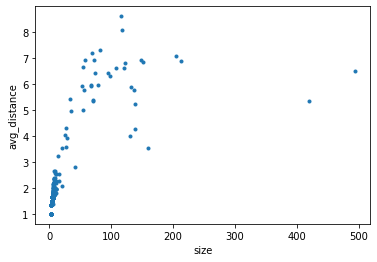

In [266]:
plt.plot(size, mod, '.')
plt.xlabel('size')
plt.ylabel('avg_distance')
plt.show()

In [267]:
common_n = lambda x, y:  len(set(x) & set(y))
match_list=tc2.community_matching(method=common_n)

In [270]:
[(x[0], len(tc2.get_community(x[0])), x[1], len(tc2.get_community(x[1])), x[2]) for x in match_list if x[2]>100]

[('2019_0', 533, '2020_0', 618, 148)]

## Link prediction

## Functional data analysis

### Data preparation

In [345]:
data=Pallottola[['Organisation', 'id_x', 'USDraised_cpi', 'Date']]

In [346]:
data.Date=data.Date.dt.year

/users/testa/.local/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [347]:
data=data[data.Date>=2000]
data=data[data.Date<2021]

In [348]:
data=data.groupby(['id_x','Organisation','Date']).sum().reset_index()

In [349]:
data=data.pivot('Date','id_x','USDraised_cpi')

In [353]:
data

id_x,0,1,2,3,4,5,6,7,8,9,...,22547,22548,22549,22550,22551,22552,22553,22554,22555,22556
Date,,,,,,,,,,,,,,,,,,,,,
2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


In [354]:
data.to_csv('to_functionalise.csv')

### Functional clustering

### Function - on - scalar and function - on - function regressions